Dataset Overview and Cleaning

Root Mean Squared Error (RMSE): 51.28


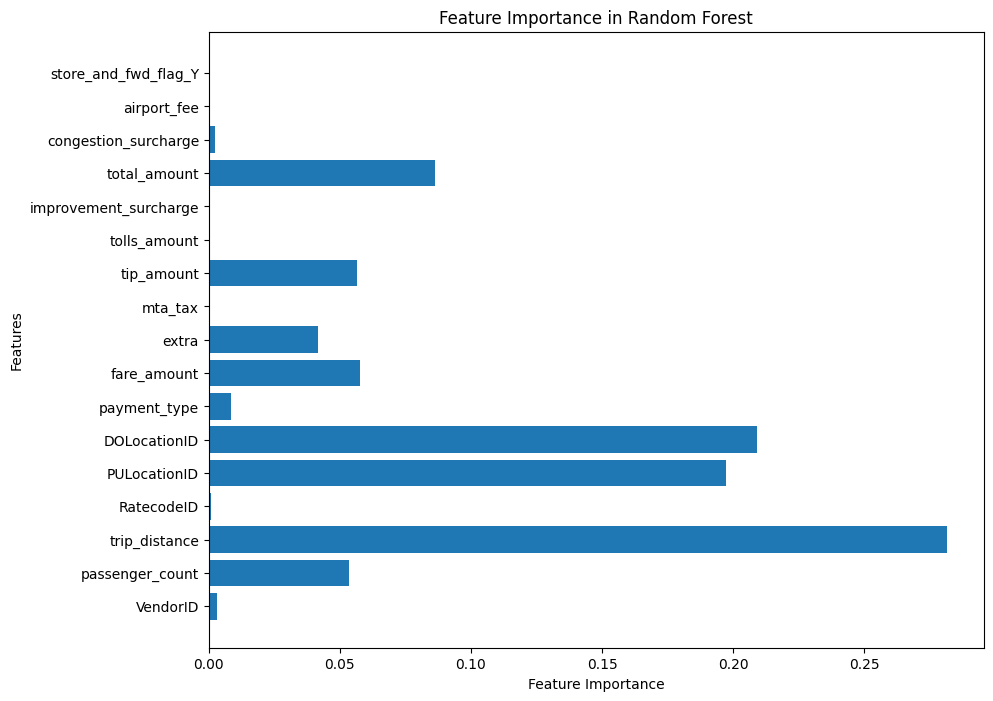

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Load the data
data_folder_path = "../data/raw/yellow_tripdata_2022-05.parquet"
df = pd.read_parquet(data_folder_path)

# Handle NaN values
missing_values_report = df.isnull().sum() / len(df) * 100
columns_to_drop = missing_values_report[missing_values_report > 50].index.tolist()
df.drop(columns=columns_to_drop, inplace=True)

numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=["object", "category"]).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Handle outliers using IQR (Interquartile Range) method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Handle outliers for the specified columns
for col in ['trip_distance', 'total_amount', 'fare_amount']:
    if col in df.columns:
        df = remove_outliers(df, col)

# Feature engineering for datetime columns
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0

# Drop rows with invalid trip durations
df = df[df['trip_duration'] > 0]

# Define target and features
target_column = 'trip_duration'
X = df.drop(columns=[target_column, 'tpep_pickup_datetime', 'tpep_dropoff_datetime'])
y = df[target_column]

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Feature importance
feature_importance = model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()


In [5]:
df[df.DOLocationID == df.PULocationID]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
83,1,2022-05-01 00:09:08,2022-05-01 00:20:33,1.000000,2.80,1.000000,N,132,132,2,11.50,1.75,0.5,0.00,0.0,0.3,14.05,0.000000,1.250000
88,2,2022-05-01 00:37:46,2022-05-01 00:38:32,1.000000,0.10,1.000000,N,249,249,2,2.50,0.50,0.5,0.00,0.0,0.3,6.30,2.500000,0.000000
96,1,2022-05-01 00:11:18,2022-05-01 00:16:18,2.000000,0.60,1.000000,N,79,79,1,5.00,3.00,0.5,1.32,0.0,0.3,10.12,2.500000,0.000000
128,2,2022-05-01 00:27:16,2022-05-01 00:30:22,2.000000,0.57,1.000000,N,263,263,1,4.00,0.50,0.5,2.34,0.0,0.3,10.14,2.500000,0.000000
132,2,2022-05-01 00:04:59,2022-05-01 00:05:29,2.000000,0.64,1.000000,N,229,229,1,4.50,0.50,0.5,0.00,0.0,0.3,8.30,2.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587927,2,2022-05-31 19:25:00,2022-05-31 19:25:09,1.393923,0.00,1.365674,N,224,224,0,15.36,0.00,0.5,4.13,0.0,0.3,22.79,2.282808,0.100836
3587990,2,2022-05-31 20:20:00,2022-05-31 20:22:00,1.393923,0.63,1.365674,N,237,237,0,9.99,0.00,0.5,0.73,0.0,0.3,14.02,2.282808,0.100836
3588011,2,2022-05-31 20:25:19,2022-05-31 20:30:05,1.393923,0.48,1.365674,N,148,148,0,9.96,0.00,0.5,2.05,0.0,0.3,15.31,2.282808,0.100836
3588020,2,2022-05-31 20:49:00,2022-05-31 20:50:00,1.393923,0.08,1.365674,N,158,158,0,9.95,0.00,0.5,2.92,0.0,0.3,16.17,2.282808,0.100836
